# Titanic - kaggle - 3rd attempt
- Final test score 0.78947
- Among top 20 %

Techniques presented in the notebook
- Hyperparameter tunning
- Majority voting
- Pipelines


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import SimpleImputer 
from sklearn.metrics import classification_report

%matplotlib inline
sns.set()

In [146]:
df = pd.read_csv('train.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Missing values are in the columns Age, Cabin and Embarked. These features will be inspected with greater detail

# Feature inspection

In [3]:
def get_group(df, x):
    grouped = df.groupby(x).agg({'PassengerId':'count', 'Survived': 'sum'})
    grouped['Ratio'] = round(grouped['Survived'] / grouped['PassengerId'], 3)
    return grouped.rename(columns={'PassengerId': 'N_passangers'}).sort_values('Ratio',ascending=False)

def add_missing_values(df, x, strategy):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    data_to_fill = df[x].values.reshape(-1,1)
    imp = imp.fit(data_to_fill)
    imputed_data = imp.transform(data_to_fill)
    df[x] = imputed_data


In [4]:
# Setting up dataframe for visualization and data inspection purposes
df_vis = df.copy()

### Sex

In [5]:
get_group(df_vis, ['Sex'])

,N_passangers,Survived,Ratio
Sex,,,
female,314,233,0.742
male,577,109,0.189


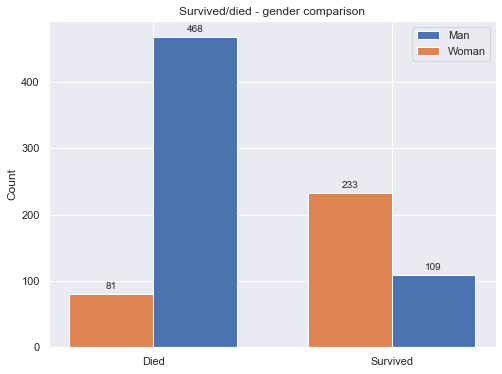

In [6]:
# Survived / died ratio - gender comparison
female = df_vis['Survived'].loc[df_vis['Sex'] == 'female'].value_counts().sort_index()
male = df_vis['Survived'].loc[df_vis['Sex'] == 'male'].value_counts().sort_index()

N = len(female)
ind = np.arange(N)
width = 0.35
labels = ['Died', 'Survived']

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)
man = ax.bar(ind + width/2, male, width, label='Man')
woman = ax.bar(ind - width/2, female, width, label='Woman')

ax.set_ylabel('Count')
ax.set_title('Survived/died - gender comparison')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(man)
autolabel(woman)

### Age

In [7]:
# Is there a nan?
any(df_vis['Age'].isnull())

True

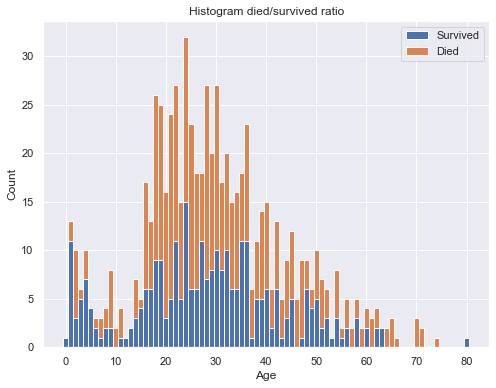

In [8]:
# Select data without NaN
data_reduced = df_vis[['Age', 'Survived']]
data_reduced = data_reduced.dropna().reset_index(drop=True)
# Round age
data_reduced['Age'] = data_reduced['Age'].apply(lambda x: round(x))

N_bars = data_reduced['Age'].max()
survived = data_reduced['Age'].loc[data_reduced['Survived'] == 1].value_counts()
died = data_reduced['Age'].loc[data_reduced['Survived'] == 0].value_counts()

for i in range(N_bars+1):
    if i not in survived:
        s = pd.Series([0], index=[i])
        survived = survived.append(s)
    if i not in died:
        s = pd.Series([0], index=[i])
        died = died.append(s)  
        
survived = survived.sort_index()
died = died.sort_index()
ind = np.arange(N_bars+1)
width = 1

fig = plt.figure(figsize=(8,6))
p1 = plt.bar(ind, survived.values, width)
p2 = plt.bar(ind, died.values, width, bottom=survived.values)
plt.ylabel('Count')
plt.title('Histogram died/survived ratio')
plt.xlabel('Age')
plt.legend((p1[0], p2[0]), ('Survived', 'Died'))

In [9]:
# Make age intervals
def age_interval(x):
    if x <= 10:
        return 'age <= 10'
    elif 10 < x <= 20:
        return '10 < age <= 20'
    elif 20 < x <= 30:
        return '20 < age <= 30'
    elif 30 < x <= 50:
        return '30 < age <= 50'
    elif 50 < x <= 70:
        return '50 < age <= 70'
    elif x > 70:
        return 'age > 70'

In [10]:
df_vis['Age_interval'] = df_vis['Age'].apply(lambda x: age_interval(x))

In [149]:
get_group(df_vis, ['Age_interval']).sort_values('Ratio',ascending=False)

,N_passangers,Survived,Ratio
Age_interval,,,
age <= 10,64,38,0.594
30 < age <= 50,241,102,0.423
10 < age <= 20,115,44,0.383
20 < age <= 30,230,84,0.365
50 < age <= 70,59,21,0.356
age > 70,5,1,0.200


#### Age - missing values
Age has highest correlation with the PClass feature. Missing values will be therefore imported based median age of Pclass groups. Sex will be also used to fill Age values.

In [163]:
df.drop(['PassengerId'],axis=1).corrwith(df['Age']).sort_values()

Pclass     -0.369226
SibSp      -0.308247
Parch      -0.189119
Survived   -0.077221
Fare        0.096067
Age         1.000000
dtype: float64

In [165]:
age_group_by_sex_pxlass = df.groupby(['Sex', 'Pclass']).median()['Age']
age_group_by_sex_pxlass

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

### PClass

In [12]:
# Is there a nan?
any(df_vis['Pclass'].isnull())

False

In [13]:
get_group(df_vis, ['Pclass'])

,N_passangers,Survived,Ratio
Pclass,,,
1,216,136,0.630
2,184,87,0.473
3,491,119,0.242


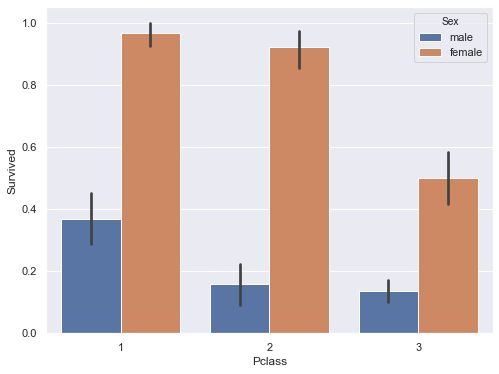

In [14]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)
ax = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=df_vis)

### Name

In [15]:
# Take titles from the names
def title(x):
    return x.split(',')[1].lstrip().split(' ')[0]

In [16]:
df_vis['Name'] = df_vis['Name'].apply(lambda x: title(x))

In [17]:
df_vis['Name'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Major.         2
Mlle.          2
Capt.          1
the            1
Sir.           1
Ms.            1
Jonkheer.      1
Don.           1
Mme.           1
Lady.          1
Name: Name, dtype: int64

In [18]:
def merge_titles(title):
    if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.']:
        title = title
    elif title in ['Ms.', 'Mme.']:
        title = 'Mrs.'
    elif title in ['Mlle.', 'Lady.']:
        title = 'Miss.'
    else:
        title = 'Other'
    return title

In [19]:
df_vis['Title'] = df_vis['Name'].apply(lambda x: merge_titles(x))

In [20]:
get_group(df_vis, ['Title'])

,N_passangers,Survived,Ratio
Title,,,
Mrs.,127,101,0.795
Miss.,185,130,0.703
Master.,40,23,0.575
Other,22,7,0.318
Mr.,517,81,0.157


### Size of the family

In [21]:
def family_size_estimation(num_family):
    if num_family == 0:
        return 'No family'
    if 0 < num_family <=3:
        return 'Small family'
    if num_family > 3:
        return 'Large family'    

In [22]:
df_vis['Family_n_size'] = df_vis.apply(lambda row: row['SibSp'] + row['Parch'],axis=1)

In [23]:
df_vis['Family_size'] = df_vis['Family_n_size'].apply(lambda x: family_size_estimation(x))

In [24]:
get_group(df_vis, ['Family_size'])

,N_passangers,Survived,Ratio
Family_size,,,
Small family,292,169,0.579
No family,537,163,0.304
Large family,62,10,0.161


### Fare

In [25]:
# Make fare intervals
def fare_intervals(x):
    if x <= 10.:
        return 'fare <= 10'
    elif 10 < x <= 30:
        return '10 < fare <= 30'
    elif 30 < x <= 50:
        return '30 < fare <= 50'
    elif 50 < x <= 100:
        return '50 < fare <= 100'
    elif x > 100:
        return 'fare > 100'

In [26]:
df_vis['fare_intervals'] = df_vis['Fare'].apply(lambda x: fare_intervals(x))

In [27]:
get_group(df_vis, ['fare_intervals'])

,N_passangers,Survived,Ratio
fare_intervals,,,
fare > 100,53,39,0.736
50 < fare <= 100,107,70,0.654
10 < fare <= 30,321,139,0.433
30 < fare <= 50,74,27,0.365
fare <= 10,336,67,0.199


### Cabins names

In [28]:
# Deal with cabins
def cabins_name(x):
    if isinstance(x, float) == True:
        return 'Unknow cabin'
    elif x[0] == 'T':
        return 'Unknow cabin'
    else:
        return x[0]

In [29]:
df_vis['Cabin_ext'] = df_vis['Cabin'].apply(lambda x: cabins_name(x))

In [30]:
get_group(df_vis, ['Cabin_ext'])

,N_passangers,Survived,Ratio
Cabin_ext,,,
D,33,25,0.758
E,32,24,0.750
B,47,35,0.745
F,13,8,0.615
C,59,35,0.593
G,4,2,0.500
A,15,7,0.467
Unknow cabin,688,206,0.299


### Embarked

In [31]:
# Is there a nan?
any(df_vis['Embarked'].isnull())

True

In [32]:
add_missing_values(df_vis, 'Embarked', 'most_frequent')

In [33]:
get_group(df_vis, ['Embarked'])

,N_passangers,Survived,Ratio
Embarked,,,
C,168,93,0.554
Q,77,30,0.390
S,646,219,0.339


# Pipeline

In [34]:
import pdpipe as pdp

In [35]:
# Preprocessing
def add_missing_values_embarked(y_frame, x='Embarked', strategy='most_frequent'):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    data_to_fill = y_frame[x].values.reshape(-1,1)
    imp = imp.fit(data_to_fill)
    imputed_data = imp.transform(data_to_fill)
    return imputed_data
    
def add_missing_values_age(y_frame, x='Age', strategy='mean'):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    data_to_fill = y_frame[x].values.reshape(-1,1)
    imp = imp.fit(data_to_fill)
    imputed_data = imp.transform(data_to_fill).round()
    return imputed_data

In [36]:
# Dropping columns
pipeline = pdp.ColDrop('Ticket')
pipeline += pdp.ColDrop('PassengerId')

# Sex - one hot encoding
pipeline += pdp.OneHotEncode('Sex',drop_first=False)

# Age - one hot encoding
pipeline += pdp.ColByFrameFunc('Age', add_missing_values_age)
pipeline += pdp.ApplyByCols('Age', age_interval) # making age intervals
pipeline += pdp.OneHotEncode('Age',drop_first=False)

# PClass - one hot encoding
pipeline += pdp.OneHotEncode('Pclass',drop_first=False)

# Names - one hot encoding
pipeline += pdp.ApplyByCols('Name', title) # Extract title from the name
pipeline += pdp.ApplyByCols('Name', merge_titles) # Merge titles together
pipeline += pdp.OneHotEncode('Name',drop_first=False)

# Size of the family 
func = lambda df: df['Parch'] + df['SibSp']
pipeline += pdp.ColByFrameFunc('Family_size', func)
pipeline += pdp.ColDrop('Parch')
pipeline += pdp.ColDrop('SibSp')
pipeline += pdp.ApplyByCols('Family_size', family_size_estimation)
pipeline += pdp.OneHotEncode('Family_size',drop_first=False)

# Fare
pipeline += pdp.ApplyByCols('Fare', fare_intervals)
pipeline += pdp.OneHotEncode('Fare',drop_first=False)

# Cabins 
pipeline += pdp.ApplyByCols('Cabin', cabins_name)
pipeline += pdp.OneHotEncode('Cabin',drop_first=False)

# Embarked
pipeline += pdp.ColByFrameFunc('Embarked', add_missing_values_embarked)
pipeline += pdp.OneHotEncode('Embarked',drop_first=False)

In [37]:
df_train = pipeline(df)

In [38]:
df_train.head()

,Survived,Sex_female,Sex_male,Age_10 < age <= 20,Age_20 < age <= 30,Age_30 < age <= 50,Age_50 < age <= 70,Age_age <= 10,Age_age > 70,Pclass_1,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_Unknow cabin,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


# Logistic regression

In [39]:
X = df_train.drop(['Survived'],axis=1)
y = df_train['Survived']

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [41]:
# Model
log_reg = LogisticRegression(random_state=101,solver='lbfgs',max_iter=1000)
scores = cross_val_score(log_reg, X, y, cv=10, scoring='accuracy', n_jobs=1)
print('K-fold CV accuracy scores: {}'.format(scores))
print()
print('CV accuracy: {} +- {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))

K-fold CV accuracy scores: [0.8        0.82222222 0.7752809  0.85393258 0.84269663 0.80898876
 0.83146067 0.80898876 0.88764045 0.84090909]

CV accuracy: 0.827 +- 0.03


### Learning curve

In [42]:
from sklearn.model_selection import learning_curve

In [43]:
train_sizes, train_scores, test_scores = learning_curve(log_reg,
                                                        X=X,
                                                        y=y,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

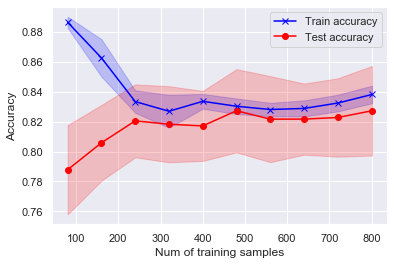

In [44]:
plt.plot(train_sizes, train_mean, label='Train accuracy', color='blue', marker='x')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_mean, label='Test accuracy', color='red', marker='o')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.2)
plt.xlabel('Num of training samples')
plt.ylabel('Accuracy')
plt.legend()

### Validation curve

In [45]:
from sklearn.model_selection import validation_curve

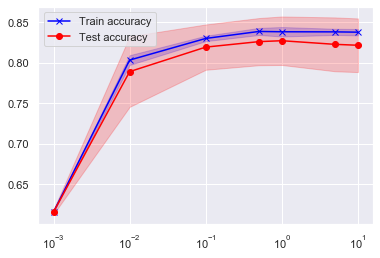

In [46]:
C_range = [0.001, 0.01, 0.1, 0.5, 1.0, 5., 10.0]

train_scores, test_scores = validation_curve(
                                            estimator=log_reg,
                                            X=X,
                                            y=y,
                                            param_name='C',
                                            param_range=C_range,
                                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(C_range, train_mean, label='Train accuracy', color='blue', marker='x')
plt.fill_between(C_range, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.2)
plt.plot(C_range, test_mean, label='Test accuracy', color='red', marker='o')
plt.fill_between(C_range, test_mean + test_std, test_mean - test_std, color='red', alpha=0.2)
plt.xscale('log')
plt.legend()

### Hyperparameter tunning

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
range_param = [0.001, 0.01, 0.1, 0.5, 0.9, 0.95, 1.0, 5., 10.0, 100., 1000.]
param_grid = [{'C': range_param,
             'penalty': ['l1', 'l2'],
              'solver': ['liblinear']
              },
              {'C': range_param,
              'penalty': ['l2', 'none'],
               'solver': ['newton-cg', 'sag', 'lbfgs']
              },
              {'C': range_param,
              'penalty': ['l1', 'none'],
               'solver': ['saga']
              }
             ]


log_reg = LogisticRegression(max_iter=5000)

gs_log_reg = GridSearchCV(log_reg, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv = 10,
                  n_jobs=-1)
gs_log_reg.fit(X,y)

Log_reg_score = gs_log_reg.best_score_
Log_reg_params = gs_log_reg.best_params_
log_reg_pred = gs_log_reg.predict(X)

print(Log_reg_score)
print(Log_reg_params)

0.8282828282828283
{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
def conf_matrix_plot(y_true, y_pred):
    sns.reset_orig()
    fig, ax = plt.subplots(figsize=(3,3))
    confmat = confusion_matrix(y_true, y_pred)
    ax.matshow(confmat, alpha=0.2)
    for i in range(confmat.shape[0]):
        for k in range(confmat.shape[1]):
            ax.text(x=k, y=i, s=confmat[i, k], va='center', ha='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return confmat

C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

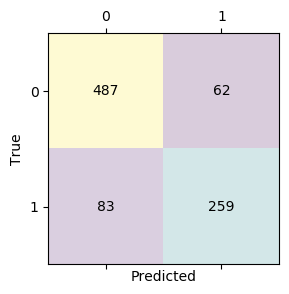

In [51]:
confmat_logreg = conf_matrix_plot(y, log_reg_pred)

### Receiver Operating Characteristic ROC

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

In [54]:
def ROC(model, X, y):
    cv = list(StratifiedKFold(n_splits=3,
                            random_state=1).split(X,y))


    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas = model.fit(X.loc[train],y.loc[train]).predict_proba(X.loc[test])
        fpr, tpr, thresholds = roc_curve(y.loc[test], probas[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label='ROC fold {} (area = {})'.format(i+1, roc_auc))

    plt.plot([0, 1],
             [0, 1],
             linestyle='--',
             color=(0.6, 0.6, 0.6),
             label='random guessing')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 0, 1],
             [0, 1, 1],
             linestyle=':',
             color='black',
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc="lower right")

    plt.tight_layout()
    
    return mean_auc

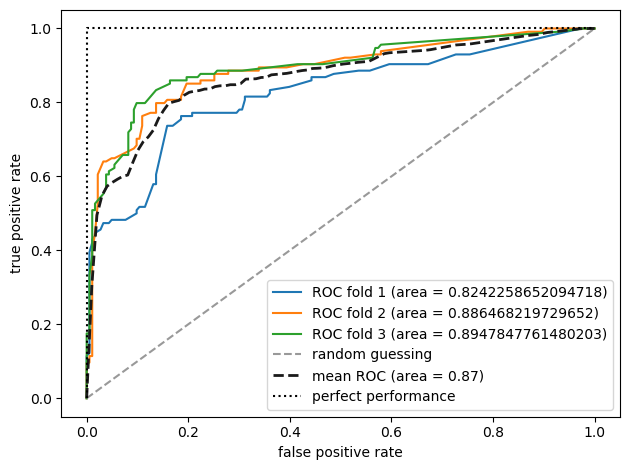

In [55]:
# Grab best parameters for log regression
C = Log_reg_params['C']
penalty = Log_reg_params['penalty']
solver = Log_reg_params['solver']

log_reg = LogisticRegression(max_iter=5000,
                             C=C, penalty=penalty, solver=solver)
mean_auc_logreg = ROC(log_reg, X, y)

In [56]:
print(classification_report(y,log_reg_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       549
           1       0.81      0.76      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



# SVM

In [57]:
from sklearn.svm import SVC

In [58]:
param_grid = [{'C': range_param,
               'kernel': ['linear']},
              {'C': range_param,
               'gamma': range_param,
               'kernel': ['rbf']}]
svc = SVC()

gs_svc = GridSearchCV(svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv = 10,
                  n_jobs=-1)
gs_svc.fit(X,y)

svm_score = gs_svc.best_score_
smv_params = gs_svc.best_params_
smv_pred = gs_svc.predict(X)

print(svm_score)
print(smv_params)

0.8327721661054994
{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}


C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

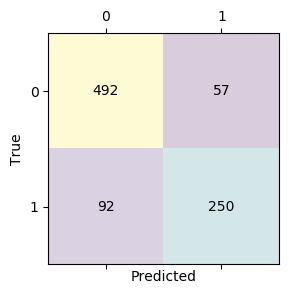

In [59]:
confmat_smv = conf_matrix_plot(y, smv_pred)

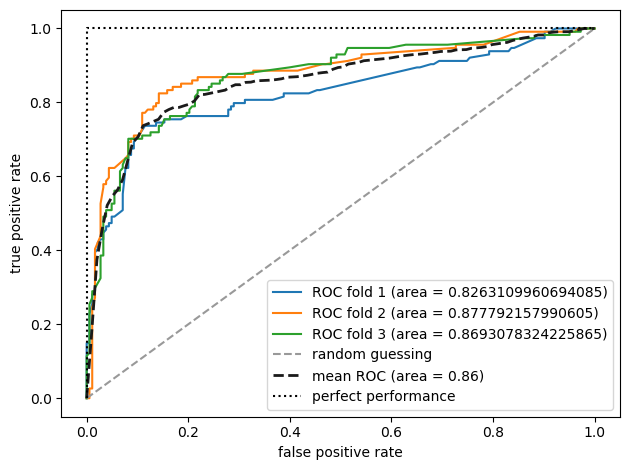

In [60]:
# Grab best parameters for svm
{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
C = smv_params['C']
gamma = smv_params['gamma']
kernel = smv_params['kernel']

svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
mean_auc_svm = ROC(svm, X, y)

In [61]:
print(classification_report(y,smv_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       549
           1       0.81      0.73      0.77       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



# DesicionTreeClassifier

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
gs_tree = GridSearchCV(DecisionTreeClassifier(),
                 param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]}],
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

gs_tree.fit(X,y)

dec_tree_score = gs_tree.best_score_
dec_tree_params = gs_tree.best_params_
dec_tree_pred = gs_tree.predict(X)

print(dec_tree_score)
print(dec_tree_params)

0.8271604938271605
{'max_depth': 3}


C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

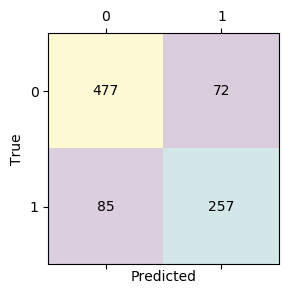

In [64]:
confmat_tree = conf_matrix_plot(y, dec_tree_pred)

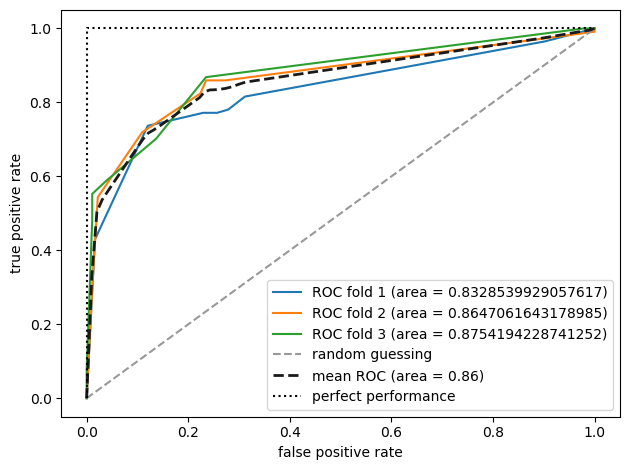

In [65]:
# Grab best parameters for svm
# {'max_depth': 3}
max_depth = dec_tree_params['max_depth']

dec_tree = DecisionTreeClassifier(max_depth=max_depth)
mean_auc_dec_tree = ROC(dec_tree, X, y)

In [66]:
print(classification_report(y,dec_tree_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       549
           1       0.78      0.75      0.77       342

    accuracy                           0.82       891
   macro avg       0.81      0.81      0.81       891
weighted avg       0.82      0.82      0.82       891



### Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [84]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80,120,140],
    'max_features':[4,5,6,7,8],
    'min_samples_leaf':[2,3,4],
    'min_samples_split':[8,10,12,14,16],
    'n_estimators': [100,200,300,500,1000]
}

forest = RandomizedSearchCV(RandomForestClassifier(),
                 param_distributions = param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=4,n_iter=100)

forest.fit(X, y)

forest_score = forest.best_score_
forest_params = forest.best_params_
forest_pred = forest.predict(X)

print(forest_score)
print(forest_params)

0.8383838383838383
{'n_estimators': 100, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 80, 'bootstrap': True}


C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Honza\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

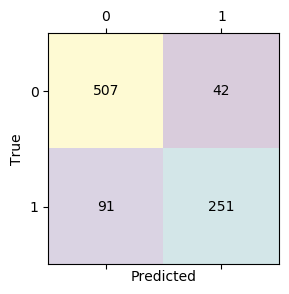

In [85]:
forest_tree = conf_matrix_plot(y, forest_pred)

0.8674858095028365

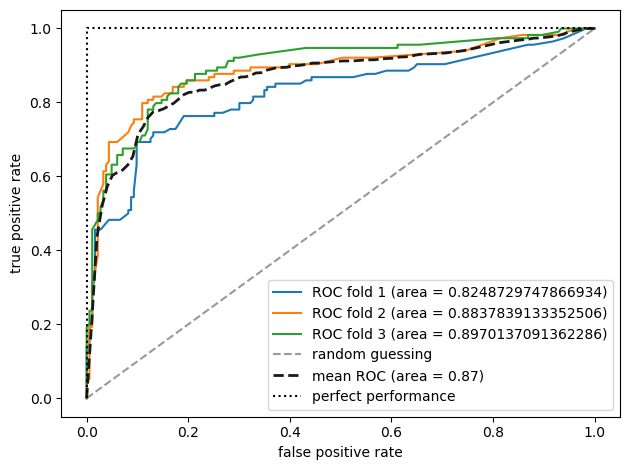

In [86]:
ROC(forest.best_estimator_, X, y)

In [92]:
importances = forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print('{}) {} {}%'.format(f+1, X.columns[f], importances[f]))

1) Sex_female 0.1885159617646112%
2) Sex_male 0.1402104068404277%
3) Age_10 < age <= 20 0.00536304968368977%
4) Age_20 < age <= 30 0.007523864755226216%
5) Age_30 < age <= 50 0.009789928050630978%
6) Age_50 < age <= 70 0.00625049593909894%
7) Age_age <= 10 0.017816400360992635%
8) Age_age > 70 0.0%
9) Pclass_1 0.021464734283215936%
10) Pclass_2 0.019041985526135136%
11) Pclass_3 0.04768068989820139%
12) Name_Master. 0.01453128539146465%
13) Name_Miss. 0.060440507341114086%
14) Name_Mr. 0.16827590044437907%
15) Name_Mrs. 0.06453299579791667%
16) Name_Other 0.005121680305095336%
17) Family_size_Large family 0.03153849727871288%
18) Family_size_No family 0.012502945037934915%
19) Family_size_Small family 0.02658533357567412%
20) Fare_10 < fare <= 30 0.014380280703816346%
21) Fare_30 < fare <= 50 0.004819074830157125%
22) Fare_50 < fare <= 100 0.012153450778376393%
23) Fare_fare <= 10 0.020038224639152523%
24) Fare_fare > 100 0.004712441470425371%
25) Cabin_A 0.0007935359043326481%
26) Cab

In [94]:
print(classification_report(y,forest_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       549
           1       0.86      0.73      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



# Majority voting

In [89]:
from sklearn.ensemble import VotingClassifier

In [115]:
eclf1 = VotingClassifier(estimators=[('forest', forest.best_estimator_), 
                                     ('tree', dec_tree), ('svm', svm), 
                                     ('log_reg', log_reg)], voting='soft', 
                                     weights=[2,1,2,1], flatten_transform=True)

eclf1.fit(X, y)
majority_pred = eclf1.predict(X)

In [116]:
print(classification_report(y,majority_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       549
           1       0.81      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.84      0.83       891



# Applying of best model to

In [117]:
# Selecting best model
scores_logreg = cross_val_score(log_reg, X, y, cv=10, scoring='accuracy')
scores_svm = cross_val_score(svm, X, y, cv=10, scoring='accuracy')
scores_tree = cross_val_score(dec_tree, X, y, cv=10, scoring='accuracy')
scores_forest = cross_val_score(forest.best_estimator_, X, y, cv=10, scoring='accuracy')
scores_voting = cross_val_score(eclf1, X, y, cv=10, scoring='accuracy')

In [118]:
scores = [scores_logreg, scores_svm, scores_tree, scores_forest, scores_voting]
labels = ['Log_Reg', 'SVM', 'Dec_Tree', 'Forest', 'Voting']

for i in range(len(scores)):
    print('Model: {} final accuracy score: {}'.format(labels[i], round(np.mean(scores[i]),3)))

Model: Log_Reg final accuracy score: 0.828
Model: SVM final accuracy score: 0.833
Model: Dec_Tree final accuracy score: 0.827
Model: Forest final accuracy score: 0.831
Model: Voting final accuracy score: 0.834


In [138]:
# Preparing test data
df_test = pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [139]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [140]:
df_test_prepare = pipeline(df_test)

In [141]:
df_test_prepare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 36 columns):
PassengerId                 418 non-null int64
Sex_female                  418 non-null int64
Sex_male                    418 non-null int64
Age_10 < age <= 20          418 non-null int64
Age_20 < age <= 30          418 non-null int64
Age_30 < age <= 50          418 non-null int64
Age_50 < age <= 70          418 non-null int64
Age_age <= 10               418 non-null int64
Age_age > 70                418 non-null int64
Pclass_1                    418 non-null int64
Pclass_2                    418 non-null int64
Pclass_3                    418 non-null int64
Name_Master.                418 non-null int64
Name_Miss.                  418 non-null int64
Name_Mr.                    418 non-null int64
Name_Mrs.                   418 non-null int64
Name_Other                  418 non-null int64
Family_size_Large family    418 non-null int64
Family_size_No family       418 non-null int64
Fa

In [143]:
X_test = df_test_prepare.drop(['PassengerId'],axis=1)
majority_pred = eclf1.predict(X_test)

In [144]:
sub = pd.DataFrame({
    'PassengerId': df_test_prepare['PassengerId'],
    'Survived': majority_pred
    })

sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [145]:
sub.to_csv('titanic_sub_3.csv', index=False)